In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data Processing

In [ ]:
columns_needed = ["SUBJECT_ID", "CHARTTIME", "ITEMID", "VALUE"]

# Read only necessary columns from CHARTEVENTS
chartevents= pd.read_csv("mimic-iii/CHARTEVENTS.csv.gz",  parse_dates=["CHARTTIME"], nrows=4000000) #you can change the nrows value here, i kept it short for shorter calculation time
print(chartevents.head())

   ROW_ID  SUBJECT_ID  HADM_ID  ICUSTAY_ID  ITEMID           CHARTTIME  \
0     788          36   165660    241249.0  223834 2134-05-12 12:00:00   
1     789          36   165660    241249.0  223835 2134-05-12 12:00:00   
2     790          36   165660    241249.0  224328 2134-05-12 12:00:00   
3     791          36   165660    241249.0  224329 2134-05-12 12:00:00   
4     792          36   165660    241249.0  224330 2134-05-12 12:00:00   

             STORETIME     CGID   VALUE  VALUENUM VALUEUOM  WARNING  ERROR  \
0  2134-05-12 13:56:00  17525.0   15.00     15.00    L/min        0      0   
1  2134-05-12 13:56:00  17525.0  100.00    100.00      NaN        0      0   
2  2134-05-12 12:18:00  20823.0    0.37      0.37      NaN        0      0   
3  2134-05-12 12:19:00  20823.0    6.00      6.00      min        0      0   
4  2134-05-12 12:19:00  20823.0    2.50      2.50      NaN        0      0   

   RESULTSTATUS  STOPPED  
0           NaN      NaN  
1           NaN      NaN  
2    

In [101]:
# Read d_items , it will be needed later for detecting ventilator related items
d_items = pd.read_csv("mimic-iii/D_ITEMS.csv.gz")
d_items.head()

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
0,457,497,Patient controlled analgesia (PCA) [Inject],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
1,458,498,PCA Lockout (Min),NaN,carevue,chartevents,NaN,NaN,NaN,NaN
2,459,499,PCA Medication,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
3,460,500,PCA Total Dose,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
4,461,501,PCV Exh Vt (Obser),NaN,carevue,chartevents,NaN,NaN,NaN,NaN


In [102]:
# Data processing for extracting ventilator related item's itemid
ventilator_keywords = ["ventilator", "respiratory", "oxygen", "intubation", "airway"]
ventilator_items = d_items[d_items['LABEL'].str.contains('|'.join(ventilator_keywords), case=False, na=False)]

# Extract the ITEMIDs
ventilator_itemids = ventilator_items['ITEMID'].unique().tolist()
print("Extracted Ventilator ITEMIDs:", ventilator_itemids)


Extracted Ventilator ITEMIDs: [1209, 616, 617, 618, 38, 39, 40, 141, 418, 444, 619, 720, 721, 722, 1864, 1865, 1672, 2988, 3605, 3681, 3689, 7146, 227210, 227211, 227212, 227213, 227214, 227215, 225475, 227047, 226814, 226815, 228643, 222871, 223059, 223990, 225585, 225586, 225587, 225588, 225590, 225592, 225593, 227032, 227035, 223985, 224688, 224689, 224690, 224697, 227565, 227566, 227567, 227568, 70057, 70058, 224745, 224385, 80177, 226166, 226188, 226189, 226190, 226191, 228232, 220210, 228192, 228193, 226767, 223848, 223849, 225271, 226429, 226430, 226431, 226432, 228065, 228066, 228067, 228068, 228069, 228070, 228071, 223836, 225291, 225292, 225294, 225295, 225296, 225297, 225298, 225300, 225301, 225302, 225303, 225304, 225306]


In [103]:
## Extract ventilator usage Data from chartevents
ventilator_data = chartevents[chartevents['ITEMID'].isin(ventilator_itemids)]
ventilator_data.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
19,807,36,165660,241249.0,220210,2134-05-12 13:00:00,2134-05-12 13:55:00,17525.0,21.0,21.0,insp/min,0,0,NaN,NaN
32,820,36,165660,241249.0,220210,2134-05-12 14:00:00,2134-05-12 14:39:00,17525.0,19.0,19.0,insp/min,0,0,NaN,NaN
45,833,36,165660,241249.0,220210,2134-05-12 15:00:00,2134-05-12 16:51:00,17525.0,20.0,20.0,insp/min,0,0,NaN,NaN
64,852,36,165660,241249.0,220210,2134-05-12 16:00:00,2134-05-12 16:51:00,17525.0,20.0,20.0,insp/min,0,0,NaN,NaN
76,329,34,144319,290505.0,224690,2191-02-23 07:00:00,2191-02-23 07:35:00,16924.0,22.0,22.0,insp/min,0,0,NaN,NaN


# Preparing ventilator data for prediction model 

In [104]:
ventilator_data['CHARTTIME'] = pd.to_datetime(ventilator_data['CHARTTIME'])
'''
taking only the data of year 2167 , 
this can be replaced with any other year where lots of data available, 
or we can get an average of counts across the months of all the years.
'''
ventilator_data_2167 = ventilator_data[ventilator_data['CHARTTIME'].dt.year == 2167]
# Aggregate ventilator usage per **month**
ventilator_time_series = ventilator_data_2167.groupby(pd.Grouper(key='CHARTTIME', freq='M'))['SUBJECT_ID'].nunique().reset_index()
# Rename columns for Prophet
ventilator_time_series.rename(columns={'CHARTTIME': 'ds', 'SUBJECT_ID': 'y'}, inplace=True)
# Sort data by month order
ventilator_time_series = ventilator_time_series.sort_values(by='ds')
ventilator_time_series.head()


C:\Users\fabli\AppData\Local\Temp\ipykernel_17148\1888712693.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ventilator_data['CHARTTIME'] = pd.to_datetime(ventilator_data['CHARTTIME'])
C:\Users\fabli\AppData\Local\Temp\ipykernel_17148\1888712693.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ventilator_time_series = ventilator_data_2167.groupby(pd.Grouper(key='CHARTTIME', freq='M'))['SUBJECT_ID'].nunique().reset_index()


,ds,y
0,2167-01-31,1
1,2167-02-28,0
2,2167-03-31,2
3,2167-04-30,4
4,2167-05-31,5


# Ventilator usage prediction across months with fbProphet 

seasonality_mode='additive', 
changepoint_prior_scale=0.1, 
fourier_order=3, 
growth='logistic'

11:14:30 - cmdstanpy - INFO - Chain [1] start processing
11:14:30 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\fabli\anaconda3\envs\selftutorial\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


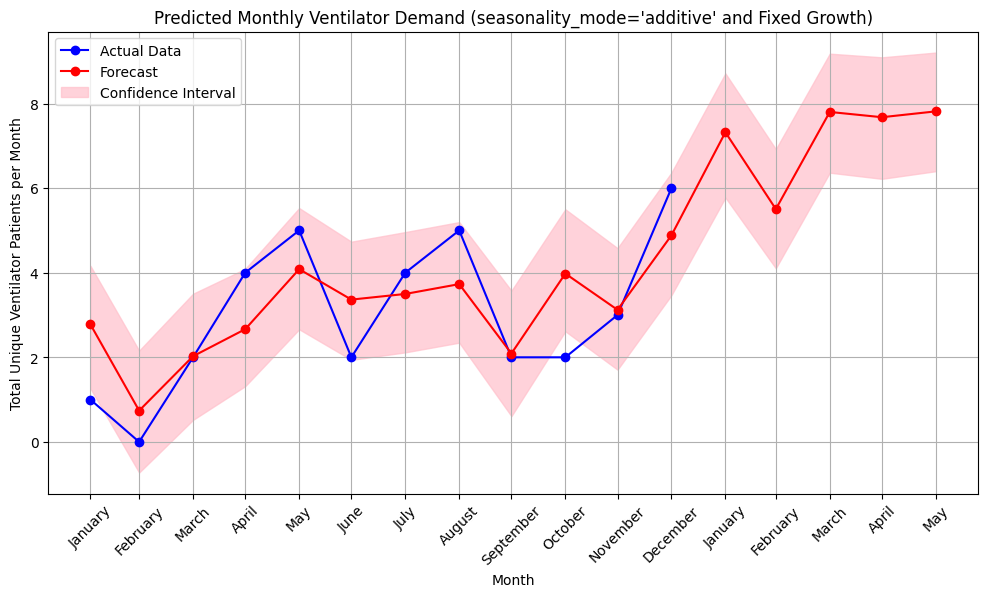

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Set Cap for Logistic Growth (It is necessary for prohibiting trends going upward continiously)
ventilator_time_series['cap'] = ventilator_time_series['y'].max() * 1.2  # Set max limit

# Train Prophet Model with Seasonality & Growth Cap
model = Prophet(growth='logistic', changepoint_prior_scale=0.1, seasonality_mode='additive')  #fbProphet consider seasonal trends by setting seasonality_mode
model.add_seasonality(name='monthly', period=12, fourier_order=3)
model.fit(ventilator_time_series)

# Create Future DataFrame for Forecasting (Next 5 Months)
future = model.make_future_dataframe(periods=5, freq='M')  # Predict next 5 months
future['cap'] = ventilator_time_series['cap'].max()  # Apply cap to future data
forecast = model.predict(future)

# Plot Fixed Forecast
plt.figure(figsize=(12, 6))

# Actual Monthly Data
plt.plot(ventilator_time_series['ds'], ventilator_time_series['y'], label="Actual Data", color="blue", linestyle='-', marker='o')

# Forecasted Monthly Data
plt.plot(forecast['ds'], forecast['yhat'], label="Forecast", color="red", linestyle='-', marker='o')

# Confidence Interval (Uncertainty)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.7, label="Confidence Interval")

# Combine historical & future dates for correct X-axis labels
all_dates = pd.concat([ventilator_time_series['ds'], forecast['ds']]).drop_duplicates()

# Format X-Axis as Month Names (Including Future)
plt.xticks(ticks=all_dates, labels=all_dates.dt.strftime('%B'), rotation=45)

# Labels & Formatting
plt.title("Predicted Monthly Ventilator Demand (seasonality_mode='additive' and Fixed Growth)")
plt.xlabel("Month")
plt.ylabel("Total Unique Ventilator Patients per Month")
plt.legend()
plt.grid(True)

# Show Plot
plt.show()


seasonality_mode='multiplicative',
changepoint_prior_scale=0.1,
fourier_order=3,
growth='logistic'

11:14:31 - cmdstanpy - INFO - Chain [1] start processing
11:14:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\fabli\anaconda3\envs\selftutorial\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


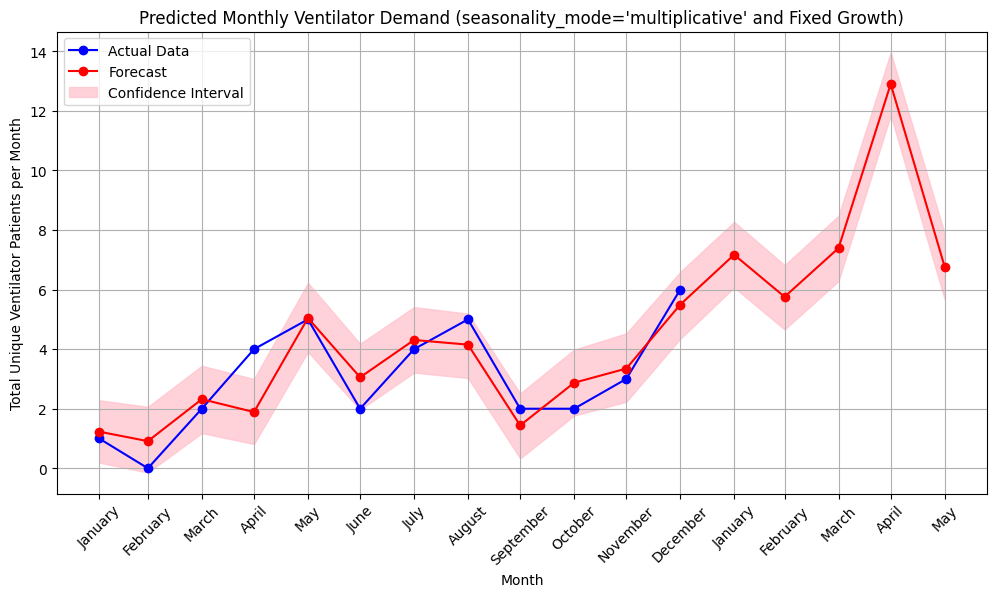

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Set Cap for Logistic Growth (It is necessary for prohibiting trends going upward continiously)
ventilator_time_series['cap'] = ventilator_time_series['y'].max() * 1.2  # Set max limit

# Train Prophet Model with Seasonality & Growth Cap
model = Prophet(growth='logistic', changepoint_prior_scale=0.1, seasonality_mode='multiplicative')  #fbProphet consider seasonal trends by setting seasonality_mode
model.add_seasonality(name='monthly', period=12, fourier_order=3)
model.fit(ventilator_time_series)

# Create Future DataFrame for Forecasting (Next 5 Months)
future = model.make_future_dataframe(periods=5, freq='M')  # Predict next 5 months
future['cap'] = ventilator_time_series['cap'].max()  # Apply cap to future data
forecast = model.predict(future)

# Plot Fixed Forecast
plt.figure(figsize=(12, 6))

# Actual Monthly Data
plt.plot(ventilator_time_series['ds'], ventilator_time_series['y'], label="Actual Data", color="blue", linestyle='-', marker='o')

# Forecasted Monthly Data
plt.plot(forecast['ds'], forecast['yhat'], label="Forecast", color="red", linestyle='-', marker='o')

# Confidence Interval (Uncertainty)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.7, label="Confidence Interval")

# Combine historical & future dates for correct X-axis labels
all_dates = pd.concat([ventilator_time_series['ds'], forecast['ds']]).drop_duplicates()

# Format X-Axis as Month Names (Including Future)
plt.xticks(ticks=all_dates, labels=all_dates.dt.strftime('%B'), rotation=45)

# Labels & Formatting
plt.title("Predicted Monthly Ventilator Demand (seasonality_mode='multiplicative' and Fixed Growth)")
plt.xlabel("Month")
plt.ylabel("Total Unique Ventilator Patients per Month")
plt.legend()
plt.grid(True)

# Show Plot
plt.show()


seasonality_mode='additive',
changepoint_prior_scale=0.1,
fourier_order=3,
no growth

11:14:32 - cmdstanpy - INFO - Chain [1] start processing
11:14:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\fabli\anaconda3\envs\selftutorial\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


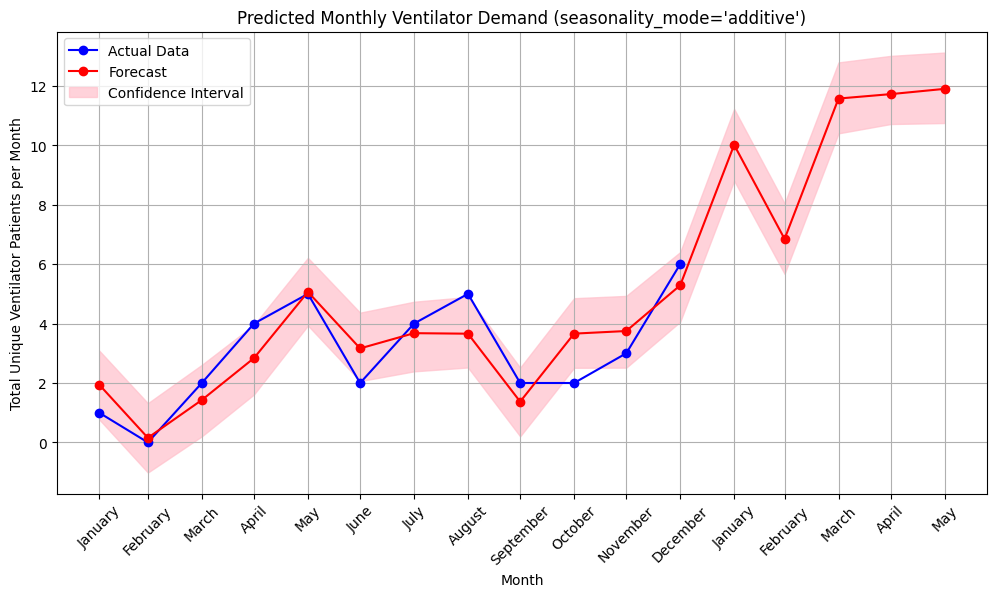

In [107]:
# Train Prophet Model with Seasonality without Growth Cap
model = Prophet( changepoint_prior_scale=0.1, seasonality_mode='additive')  #fbProphet consider seasonal trends by setting seasonality_mode
model.add_seasonality(name='monthly', period=12, fourier_order=3)
model.fit(ventilator_time_series)

# Create Future DataFrame for Forecasting (Next 5 Months)
future = model.make_future_dataframe(periods=5, freq='M')  # Predict next 5 months
forecast = model.predict(future)

# Plot Fixed Forecast
plt.figure(figsize=(12, 6))

# Actual Monthly Data
plt.plot(ventilator_time_series['ds'], ventilator_time_series['y'], label="Actual Data", color="blue", linestyle='-', marker='o')

# Forecasted Monthly Data
plt.plot(forecast['ds'], forecast['yhat'], label="Forecast", color="red", linestyle='-', marker='o')

# Confidence Interval (Uncertainty)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.7, label="Confidence Interval")

# Combine historical & future dates for correct X-axis labels
all_dates = pd.concat([ventilator_time_series['ds'], forecast['ds']]).drop_duplicates()

# Format X-Axis as Month Names (Including Future)
plt.xticks(ticks=all_dates, labels=all_dates.dt.strftime('%B'), rotation=45)

# Labels & Formatting
plt.title("Predicted Monthly Ventilator Demand (seasonality_mode='additive')")
plt.xlabel("Month")
plt.ylabel("Total Unique Ventilator Patients per Month")
plt.legend()
plt.grid(True)

# Show Plot
plt.show()


seasonality_mode='multiplicative',
changepoint_prior_scale=0.1,
fourier_order=3,
no growth

11:14:32 - cmdstanpy - INFO - Chain [1] start processing
11:14:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\fabli\anaconda3\envs\selftutorial\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


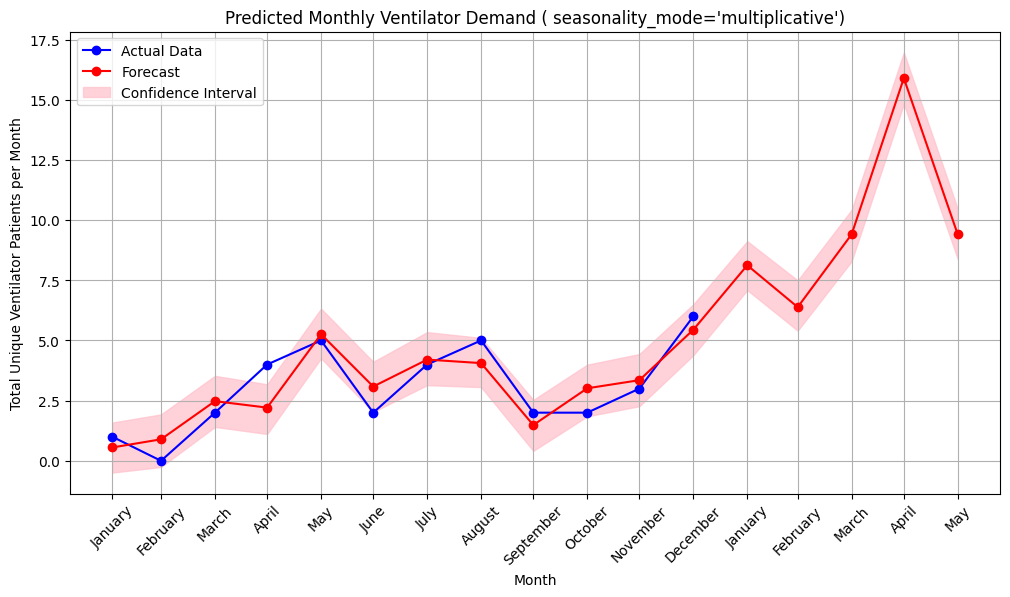

In [108]:

# Train Prophet Model with multiplicative Seasonality without Growth Cap
model = Prophet( changepoint_prior_scale=0.1, seasonality_mode='multiplicative')  #fbProphet consider seasonal trends by setting seasonality_mode
model.add_seasonality(name='monthly', period=12, fourier_order=3)
model.fit(ventilator_time_series)

# Create Future DataFrame for Forecasting (Next 5 Months)
future = model.make_future_dataframe(periods=5, freq='M')  # Predict next 5 months
forecast = model.predict(future)

# Plot Fixed Forecast
plt.figure(figsize=(12, 6))

# Actual Monthly Data
plt.plot(ventilator_time_series['ds'], ventilator_time_series['y'], label="Actual Data", color="blue", linestyle='-', marker='o')

# Forecasted Monthly Data
plt.plot(forecast['ds'], forecast['yhat'], label="Forecast", color="red", linestyle='-', marker='o')

# Confidence Interval (Uncertainty)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.7, label="Confidence Interval")

# Combine historical & future dates for correct X-axis labels
all_dates = pd.concat([ventilator_time_series['ds'], forecast['ds']]).drop_duplicates()

# Format X-Axis as Month Names (Including Future)
plt.xticks(ticks=all_dates, labels=all_dates.dt.strftime('%B'), rotation=45)

# Labels & Formatting
plt.title("Predicted Monthly Ventilator Demand ( seasonality_mode='multiplicative')")
plt.xlabel("Month")
plt.ylabel("Total Unique Ventilator Patients per Month")
plt.legend()
plt.grid(True)

# Show Plot
plt.show()


seasonality_mode='additive',
changepoint_prior_scale=0.1,
fourier_order=3,
different growth cap value 

11:14:33 - cmdstanpy - INFO - Chain [1] start processing
11:14:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\fabli\anaconda3\envs\selftutorial\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


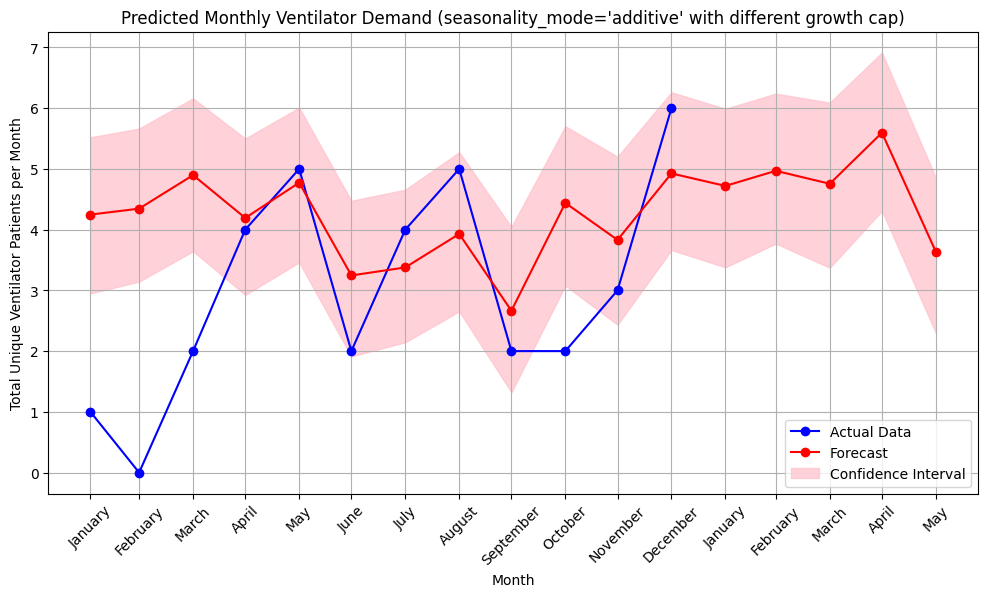

In [109]:
# Different Cap for Logistic Growth (It is necessary for prohibiting trends going upward continiously)
ventilator_time_series['cap'] = ventilator_time_series['y'].rolling(window=3, min_periods=1).mean() * 1.2

# Train Prophet Model with Seasonality & Growth Cap
model = Prophet(growth='logistic', changepoint_prior_scale=0.1, seasonality_mode='additive')  #fbProphet consider seasonal trends by setting seasonality_mode
model.add_seasonality(name='monthly', period=12, fourier_order=3)
model.fit(ventilator_time_series)

# Create Future DataFrame for Forecasting (Next 5 Months)
future = model.make_future_dataframe(periods=5, freq='M')  # Predict next 5 months
future['cap'] = ventilator_time_series['cap'].max()  # Apply cap to future data
forecast = model.predict(future)

# Plot Fixed Forecast
plt.figure(figsize=(12, 6))

# Actual Monthly Data
plt.plot(ventilator_time_series['ds'], ventilator_time_series['y'], label="Actual Data", color="blue", linestyle='-', marker='o')

# Forecasted Monthly Data
plt.plot(forecast['ds'], forecast['yhat'], label="Forecast", color="red", linestyle='-', marker='o')

# Confidence Interval (Uncertainty)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.7, label="Confidence Interval")

# Combine historical & future dates for correct X-axis labels
all_dates = pd.concat([ventilator_time_series['ds'], forecast['ds']]).drop_duplicates()

# Format X-Axis as Month Names (Including Future)
plt.xticks(ticks=all_dates, labels=all_dates.dt.strftime('%B'), rotation=45)

# Labels & Formatting
plt.title("Predicted Monthly Ventilator Demand (seasonality_mode='additive' with different growth cap)")
plt.xlabel("Month")
plt.ylabel("Total Unique Ventilator Patients per Month")
plt.legend()
plt.grid(True)

# Show Plot
plt.show()


seasonality_mode='multiplicative',
changepoint_prior_scale=0.1,
fourier_order=3,
different growth cap value

11:14:34 - cmdstanpy - INFO - Chain [1] start processing
11:14:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\fabli\anaconda3\envs\selftutorial\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


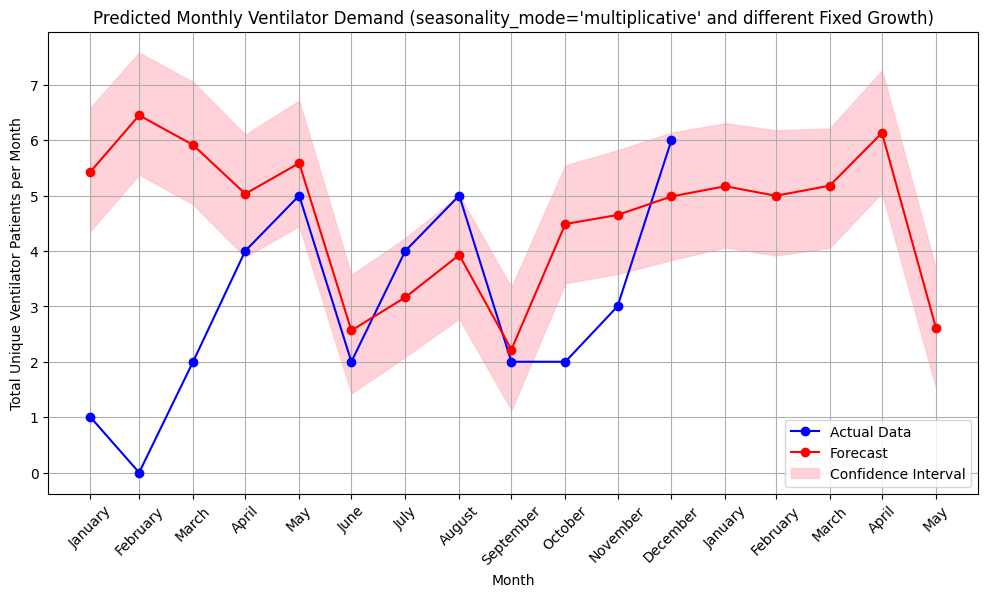

In [110]:
# Different Cap for Logistic Growth (It is necessary for prohibiting trends going upward continiously)
ventilator_time_series['cap'] = ventilator_time_series['y'].rolling(window=3, min_periods=1).mean() * 1.2

# Train Prophet Model with Seasonality & Growth Cap
model = Prophet(growth='logistic', changepoint_prior_scale=0.1, seasonality_mode='multiplicative')  #fbProphet consider seasonal trends by setting seasonality_mode
model.add_seasonality(name='monthly', period=12, fourier_order=3)
model.fit(ventilator_time_series)

# Create Future DataFrame for Forecasting (Next 5 Months)
future = model.make_future_dataframe(periods=5, freq='M')  # Predict next 5 months
future['cap'] = ventilator_time_series['cap'].max()  # Apply cap to future data
forecast = model.predict(future)

# Plot Fixed Forecast
plt.figure(figsize=(12, 6))

# Actual Monthly Data
plt.plot(ventilator_time_series['ds'], ventilator_time_series['y'], label="Actual Data", color="blue", linestyle='-', marker='o')

# Forecasted Monthly Data
plt.plot(forecast['ds'], forecast['yhat'], label="Forecast", color="red", linestyle='-', marker='o')

# Confidence Interval (Uncertainty)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.7, label="Confidence Interval")

# Combine historical & future dates for correct X-axis labels
all_dates = pd.concat([ventilator_time_series['ds'], forecast['ds']]).drop_duplicates()

# Format X-Axis as Month Names (Including Future)
plt.xticks(ticks=all_dates, labels=all_dates.dt.strftime('%B'), rotation=45)

# Labels & Formatting
plt.title("Predicted Monthly Ventilator Demand (seasonality_mode='multiplicative' and different Fixed Growth)")
plt.xlabel("Month")
plt.ylabel("Total Unique Ventilator Patients per Month")
plt.legend()
plt.grid(True)

# Show Plot
plt.show()


seasonality_mode='multiplicative',
changepoint_prior_scale=0.5,
fourier_order=3

11:37:24 - cmdstanpy - INFO - Chain [1] start processing
11:37:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\fabli\anaconda3\envs\selftutorial\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


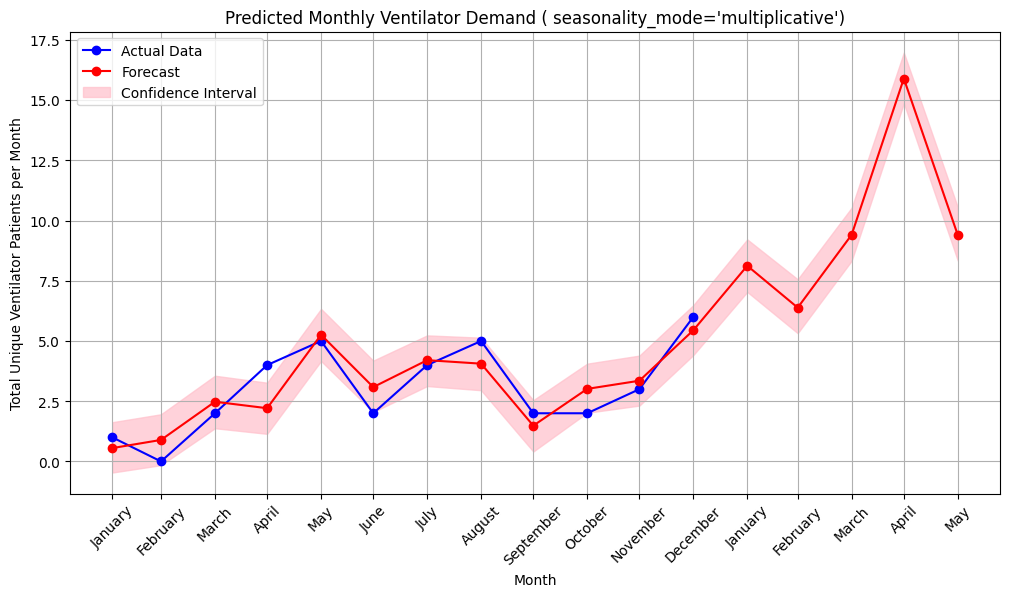

In [112]:

# Train Prophet Model with multiplicative Seasonality without Growth Cap, changepoint_prior_scale value increased
model = Prophet( changepoint_prior_scale=0.5, seasonality_mode='multiplicative')  #fbProphet consider seasonal trends by setting seasonality_mode
model.add_seasonality(name='monthly', period=12, fourier_order=3)
model.fit(ventilator_time_series)

# Create Future DataFrame for Forecasting (Next 5 Months)
future = model.make_future_dataframe(periods=5, freq='M')  # Predict next 5 months
forecast = model.predict(future)

# Plot Fixed Forecast
plt.figure(figsize=(12, 6))

# Actual Monthly Data
plt.plot(ventilator_time_series['ds'], ventilator_time_series['y'], label="Actual Data", color="blue", linestyle='-', marker='o')

# Forecasted Monthly Data
plt.plot(forecast['ds'], forecast['yhat'], label="Forecast", color="red", linestyle='-', marker='o')

# Confidence Interval (Uncertainty)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.7, label="Confidence Interval")

# Combine historical & future dates for correct X-axis labels
all_dates = pd.concat([ventilator_time_series['ds'], forecast['ds']]).drop_duplicates()

# Format X-Axis as Month Names (Including Future)
plt.xticks(ticks=all_dates, labels=all_dates.dt.strftime('%B'), rotation=45)

# Labels & Formatting
plt.title("Predicted Monthly Ventilator Demand ( seasonality_mode='multiplicative')")
plt.xlabel("Month")
plt.ylabel("Total Unique Ventilator Patients per Month")
plt.legend()
plt.grid(True)

# Show Plot
plt.show()
